In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

import plotly.graph_objects as go
from scipy.spatial.distance import squareform, pdist
from scipy.ndimage import rotate

import torch

from sklearn.metrics.pairwise import haversine_distances as h_dists
import anytree
import umgw
import networkx as nx
from PIL import Image,ImageFilter, ImageOps

In [2]:
def img2atomic(img):
    '''
    Creates a discrete measure from an image.
    '''
    assert img.ndim == 2, "img needs to be 2d array"
    x, y = img.shape
    pts = np.stack([grid.flatten() for grid in np.meshgrid(np.arange(x), y-np.arange(y))], axis=1)
    return pts[img.flatten() > 0], img.flatten()[img.flatten() > 0]

In [3]:
def plot_on_sphere(heights,n,m,l = LightSource(azdeg = 5,altdeg = 50),ax = None,view_init = [5,90],s =1 ):
    # Make data
    u = np.linspace(0, 2*np.pi,n)
    v = np.linspace(0, np.pi,m)#,endpoint=True)
    rad = 1
    x = rad * np.outer(np.cos(u), np.sin(v))
    y = rad * np.outer(np.sin(u), np.sin(v))
    z = rad * np.outer(np.ones(np.size(u)), np.cos(v))

    if ax is None:
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(121,projection='3d')
        ax.plot_surface(x, y, z,rstride=1,cstride=1,lightsource=l,facecolors = cm.viridis(s*heights.reshape(n,m)))
        ax.axis("off")

        ax.set_xlim(-0.8,0.8)
        ax.set_ylim(-0.8,0.8)
        ax.set_zlim(-0.8,0.8)

        ax.view_init(elev=view_init[0], azim=view_init[1],roll=view_init[2])
    else:
        
        # Plot the surface
        ax.plot_surface(x, y, z,rstride=1,cstride=1,lightsource=l,antialiased=True,facecolors = cm.viridis(s*heights.reshape(n,m)),shade=False)
        ax.view_init(elev=view_init[0], azim=view_init[1],roll=view_init[2])
        ax.set_xlim(-0.8,0.8)
        ax.set_ylim(-0.8,0.8)
        ax.set_zlim(-0.8,0.8)

        return None

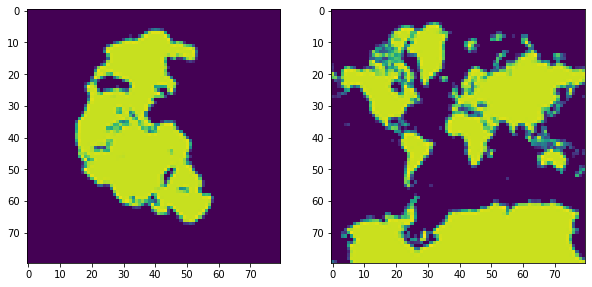

In [4]:
im1,im2 = np.loadtxt("earth_0"),np.loadtxt("earth_1")
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im1)
ax[1].imshow(im2)
plt.show()

n,m = np.shape(im1)

In [5]:
# On spheres

In [6]:
s_im1 = Image.fromarray(im1)
s_im1 = s_im1.rotate(90)
s_im1 = np.array(s_im1)
s_im1 = np.flip(s_im1,axis=0)

s_im2 = Image.fromarray(im2)
s_im2 = s_im2.rotate(90)
s_im2 = np.array(s_im2)
s_im2 = np.flip(s_im2,axis=0)

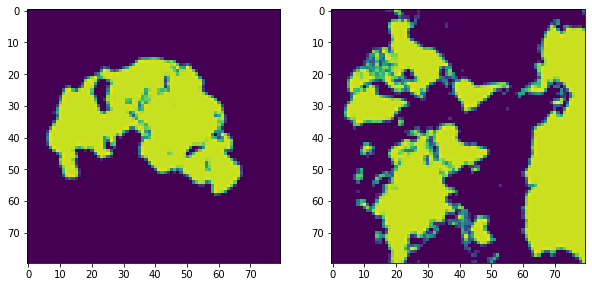

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(s_im1)
ax[1].imshow(s_im2)
plt.show()

In [8]:
# Make sphere
u = np.linspace(0, 2*np.pi, n)
v = np.linspace(0, np.pi, m)
rad = 1
x = rad * np.outer(np.cos(u), np.sin(v))
y = rad * np.outer(np.sin(u), np.sin(v))
z = rad * np.outer(np.ones(np.size(u)), np.cos(v))

In [9]:
#spherical normilization
s_im1 = np.array([np.sin(v[i]) * im for i,im in enumerate(s_im1.T)]).T
s_im2 = np.array([np.sin(v[i]) * im for i,im in enumerate(s_im2.T)]).T

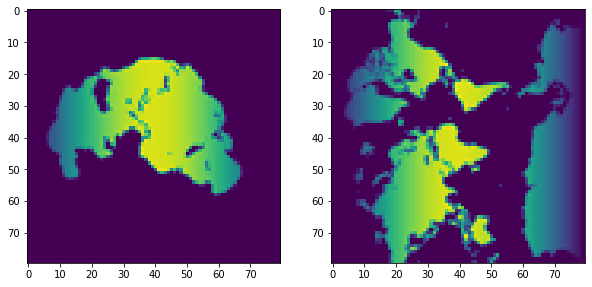

In [10]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(s_im1)
ax[1].imshow(s_im2)
plt.show()

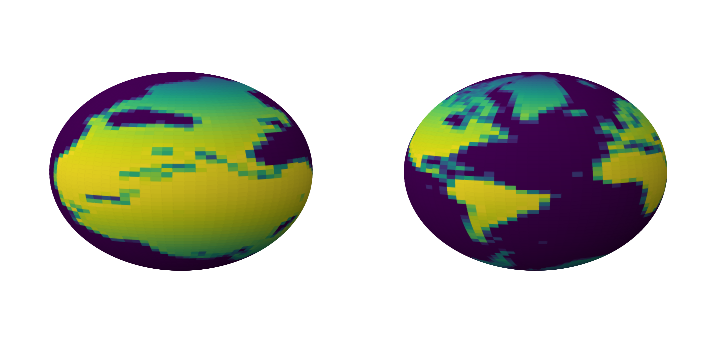

In [11]:
## import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')

# Plot the surface
l = LightSource(azdeg = 5,altdeg = 50)
ax1.plot_surface(x, y, z,rstride=1,cstride=1,lightsource=l,facecolors = cm.viridis(s_im1))
ax1.axis("off")

ax1.set_xlim(-0.8,0.8)
ax1.set_ylim(-0.8,0.8)
ax1.set_zlim(-0.8,0.8)

ax1.view_init(elev=5, azim=140)
ax2 = fig.add_subplot(122,projection='3d')

# Plot the surface
l = LightSource(azdeg = 5,altdeg = 50)
ax2.plot_surface(x, y, z,rstride=1,cstride=1,lightsource=l,facecolors = cm.viridis(s_im2))
ax2.axis("off")

ax2.set_xlim(-0.8,0.8)
ax2.set_ylim(-0.8,0.8)
ax2.set_zlim(-0.8,0.8)

ax2.view_init(elev=5, azim=140)

plt.tight_layout()
plt.show()

In [12]:
def mm_from_pos_sphere(pos):
    p1 = pos[:, np.newaxis, :]
    p2 = pos[np.newaxis, :, :]
    dot_product_matrix = np.sum(p1 * p2, axis=-1)
    dot_product_matrix = np.minimum(dot_product_matrix, 1)
    dot_product_matrix = np.maximum(dot_product_matrix, -1)
    out = np.arccos(dot_product_matrix)
    return out

In [13]:
pos_sphere = np.stack([x.ravel(),y.ravel(),z.ravel()],axis=1)

s_pos1 = pos_sphere[s_im1.flatten() != 0]
s_mu1 = torch.from_numpy(s_im1.flatten()[s_im1.flatten() != 0]).double()
s_mu1 /= torch.sum(s_mu1)
s_M1 = torch.from_numpy(mm_from_pos_sphere(s_pos1)).double()
s_pos1 = torch.from_numpy(s_pos1).double()

s_pos2 = pos_sphere[s_im2.flatten() != 0]
s_mu2 = torch.from_numpy(s_im2.flatten()[s_im2.flatten() != 0]).double()
s_mu2 /= torch.sum(s_mu2)
s_M2 = torch.from_numpy(mm_from_pos_sphere(s_pos2)).double()
s_pos2 = torch.from_numpy(s_pos2).double()


In [14]:
#barycenter
M_Y = torch.from_numpy(mm_from_pos_sphere(pos_sphere)).double()

In [15]:
#compute barycenters
barys = []
eps = 0.0003
for t in [0.2,0.4,0.6,0.8]:

    r = anytree.AnyNode(id=0)
    n1 = anytree.AnyNode(id=1,parent=r)
    n2 = anytree.AnyNode(id=2,parent=n1)
    print(anytree.RenderTree(r))

    forward = [node for node in anytree.PreOrderIter(r)]

    #earth_0
    r.mu = s_mu1
    r.M = s_M1 /np.pi
    r.rho = torch.Tensor([torch.inf])
    r.sep = None

    #barycenter
    n1.rho = torch.Tensor([0])
    n1.M = M_Y /np.pi
    n1.len = len(M_Y)
    n1.sep = None
    n1.t = 1-t

    #earth_1
    n2.rho = torch.Tensor([torch.inf])
    n2.mu = s_mu2
    n2.M = s_M2 /np.pi
    n2.sep = None
    n2.t = t

    result = umgw.UMGW_sep(r,eps= eps,rho=None,plan_cvgce_thres=1e-6,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 300,random_state = 0,log=False)
    barys.append(n1.marginal.reshape(n,m))

AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 46 iterations with last update 7.418829211589532e-07.
AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 111 iterations with last update 8.568489673185846e-07.
AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 51 iterations with last update 7.220334683092372e-07.
AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 66 iterations with last update 9.541072790286557e-07.


AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 201 iterations with last update 9.715140971476867e-07.


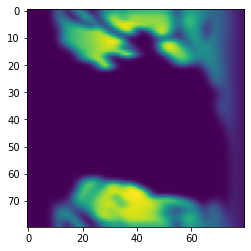

AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 31 iterations with last update 7.156948150499835e-07.


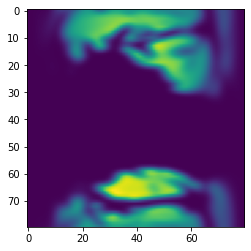

AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 26 iterations with last update 5.942631071216895e-07.


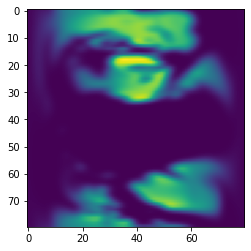

AnyNode(id=0)
└── AnyNode(id=1)
    └── AnyNode(id=2)
Terminated after 86 iterations with last update 9.817383424251053e-07.


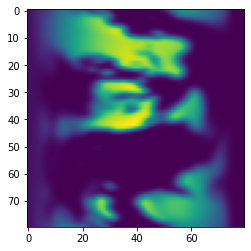

In [19]:
#compute barycenters
barys = []
eps = 0.0003
for t in [0.2,0.4,0.6,0.8]:

    r = anytree.AnyNode(id=0)
    n1 = anytree.AnyNode(id=1,parent=r)
    n2 = anytree.AnyNode(id=2,parent=n1)

    forward = [node for node in anytree.PreOrderIter(r)]

    #earth_0
    r.mu = s_mu1
    r.M = s_M1 /np.pi
    r.rho = torch.Tensor([torch.inf])
    r.sep = None

    #barycenter
    n1.rho = torch.Tensor([0])
    n1.M = M_Y /np.pi
    n1.len = len(M_Y)
    n1.sep = None
    n1.t = 1-t

    #earth_1
    n2.rho = torch.Tensor([torch.inf])
    n2.mu = s_mu2
    n2.M = s_M2 /np.pi
    n2.sep = None
    n2.t = t

    result = umgw.UMGW_sep(r,eps= eps,rho=None,plan_cvgce_thres=1e-6,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 300,random_state = 0,log=False)
    barys.append(n1.marginal.reshape(n,m))

In [ ]:
#for i in range(4):
#    np.savetxt("barys_{0}".format(i),barys[i])

In [19]:
#barys = [np.loadtxt("barys_{0}".format(i)) for i in range(4)]

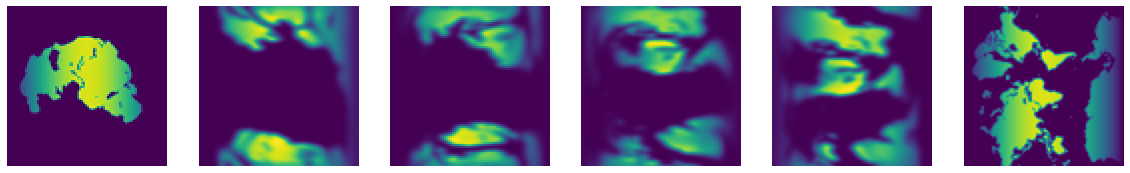

In [20]:
fig,ax = plt.subplots(1,6,figsize=(20,5))
for a in ax.ravel():
    a.axis("off")
ax[0].imshow(s_im1)
ax[-1].imshow(s_im2)
for i in range(4):
    ax[i+1].imshow(barys[i])

In [21]:
def fr(im):
    tmp = np.flip(im,axis=0)
    tmp = Image.fromarray(tmp)
    tmp = tmp.rotate(-90)
    tmp = np.array(tmp)
    return tmp

In [22]:
def t(im,m):
    out = np.zeros(np.shape(im))
    out[:,:m] = im[:,80-m:]
    out[:,m:] = im[:,:80-m]
    return out

In [23]:
vmax = np.max(np.concatenate([barys,[s_im1/np.sum(s_im1),s_im2/np.sum(s_im2)]]))

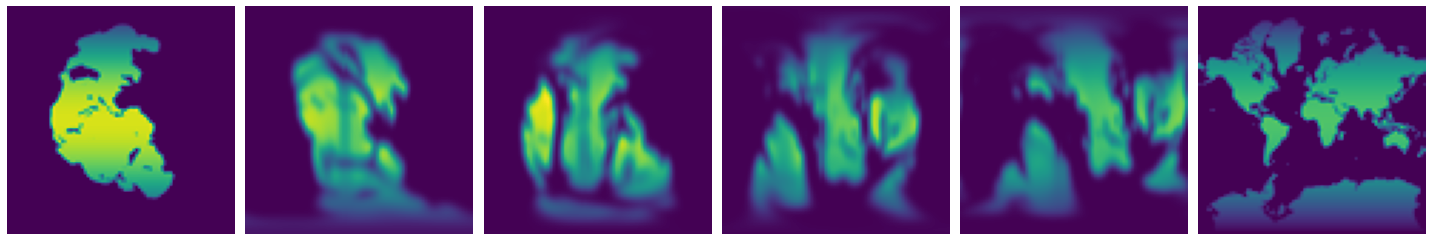

In [24]:
#plot result
fig,ax = plt.subplots(1,6,figsize=(20,5))
for a in ax.ravel():
    a.axis("off")

ax[0].imshow(fr(s_im1)/np.sum(s_im1),vmin=0)
ax[-1].imshow(fr(s_im2)/np.sum(s_im2),vmax=vmax)
for i in range(4):
    im = fr(barys[i])
    im = t(im,35)
    ax[i+1].imshow(im,vmin=0,vmax=vmax)
plt.tight_layout()

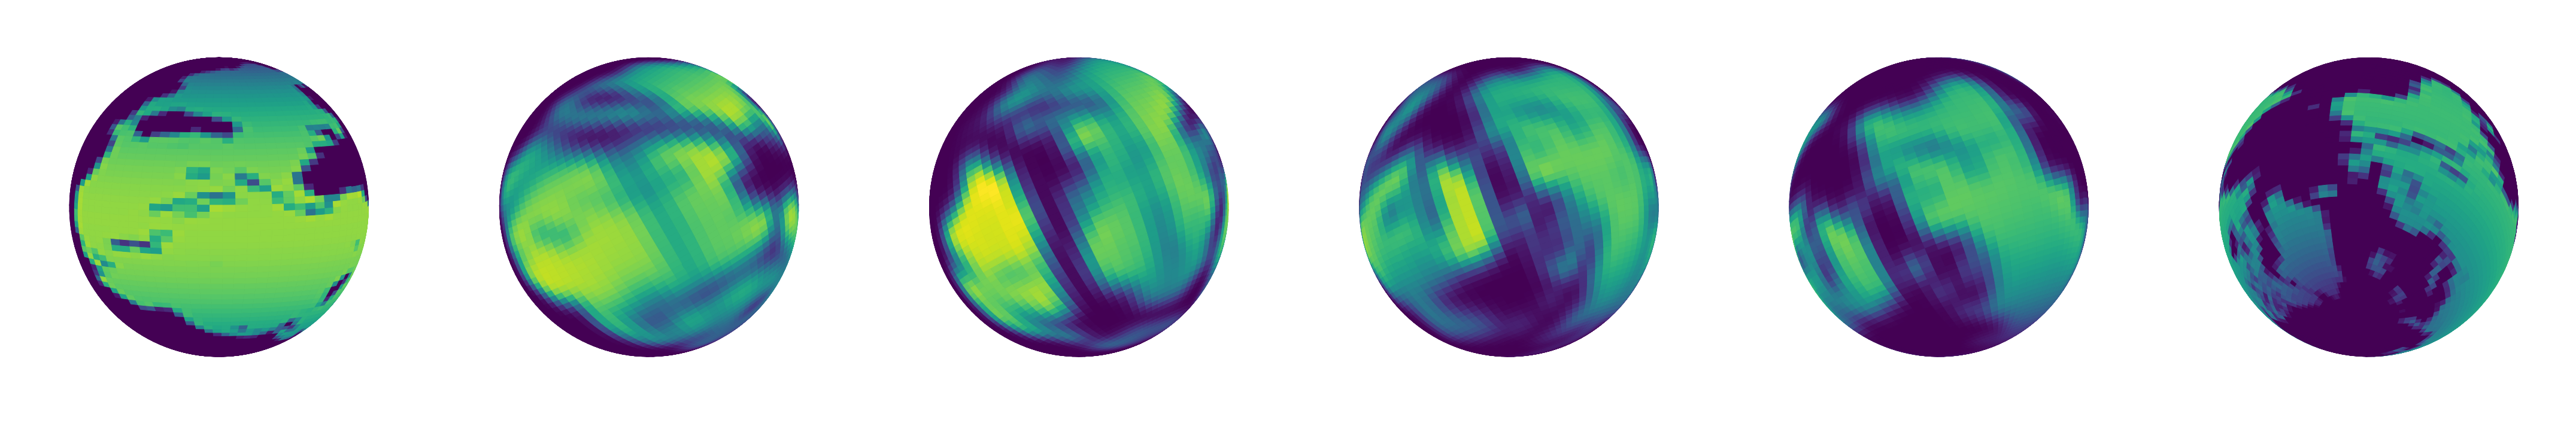

In [25]:
#plot on sphere
s = 1

fig = plt.figure(figsize=(60,10))
axs = [fig.add_subplot(161,projection='3d',aspect="equal"),
       fig.add_subplot(162,projection='3d',aspect="equal"),
       fig.add_subplot(163,projection='3d',aspect="equal"),
       fig.add_subplot(164,projection='3d',aspect="equal"),
       fig.add_subplot(165,projection='3d',aspect="equal"),
       fig.add_subplot(166,projection='3d',aspect="equal")]

l = LightSource(azdeg = 5,altdeg = 30)

#view_init = [-10]
for ax in axs:
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.8,0.8)
    ax.set_zlim(-0.8,0.8)
    ax.axis("off")
    
norm = plt.Normalize(vmin=0, vmax=vmax) 

plot_on_sphere(norm(s_im1/np.sum(s_im1)),n,m,view_init=[5,140,0],l=l,ax=axs[0],s = 1/np.max(s_im1))
plot_on_sphere(norm(np.flip(s_im2/np.sum(s_im2),axis=0)),n,m,view_init=[45,-180,170],l=l,ax=axs[-1],s = 1/np.max(s_im2))

for i in range(4):
    view_init = [5,140,0]
    if i == 0:
        view_init = [5,0,30]
    elif i == 1:
        view_init = [-5,-25,25]
    elif i == 2:
        #view_init = [-50,110,70]
        view_init = [5,70,200]
    elif i == 3:
        #view_init = [-50,140,90]
        view_init = [5,90,200]
    #view_init = np.array(view_init) + np.array([-40,320,-170])
    plot_on_sphere(norm(barys[i]),n,m,view_init=view_init,l=l,ax=axs[i+1],s = s)
    
plt.tight_layout()
plt.show()

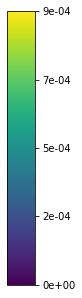

In [26]:
#plot colorbar
fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = cm.viridis
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical',format="%.0e")
cbar.set_ticks(np.arange(5)/4 * float(vmax))
plt.show()